# SIA Assignment 3: Characterising the orbits and masses of extrasolar planets

In this assignment, you will work with the same 5-hour long observation of HR 8799bcde from the week 6 workshop. Now we are going to go beyond detecting the 4 planets, to extracting astrometry and photometry for each planet.  

The two image analysis steps that you will be marked on (20% each, with an additional 30% of the mark based on code efficiency, structure, and comments) are: 

1) to measure the on-sky separation between each planet and star in units of astronomical units (AU) and compare to solar system planets
2) to measure the brightness of each planet and use exoplanet models to estimate the mass of each planet.

In addition, up to 30% of the mark on this assignment is based on evidence for version control, which is especially important when working as a group.  Thus, please use the last cell in this notebook (in markdown mode) to keep a log of changes as you work on this assignment.  

In [1]:
# import a number of critical python packages
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch, ImageNormalize
from scipy import ndimage
import scipy.linalg as la
import matplotlib.ticker as ticker
from tqdm import tqdm
from astropy.table import Table
from scipy import interpolate

# python packages for astrometry / photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats
from photutils.aperture import aperture_photometry

Some useful functions to implement PCA from the workshop:

In [2]:
def calc_KL_basis(covar_psfs, ref_psfs_mean_sub, numbasis=200):

    # Given a covariance matrix built from an array of reference PSFs, calculate the eigenvectors, eigenvectors, and resulting K-L basis set.
    # Adapted from: https://pyklip.readthedocs.io/en/latest/
    max_basis = np.max(numbasis) + 1
    tot_basis = covar_psfs.shape[0]

    evals, evecs = la.eigh(covar_psfs, subset_by_index=[tot_basis-max_basis, tot_basis-1])

    # scipy.linalg.eigh spits out the eigenvalues/vectors smallest first so we need to reverse
    # we're going to recopy them to hopefully improve caching when doing matrix multiplication
    evals = np.copy(evals[::-1])
    evecs = np.copy(evecs[:,::-1], order='F') #fortran order to improve memory caching in matrix multiplication

    # calculate the KL basis vectors
    kl_basis = np.dot(ref_psfs_mean_sub.T, evecs)

    # multiply by 1 / sqrt(eigenvalues)    
    kl_basis = kl_basis * (1. / np.sqrt(evals * (kl_basis.shape[0] - 1)))[None, :]  #multiply a value for each row

    return(kl_basis)            

In [3]:
def make_KLIP_psf(im, kl_basis, numbasis=200):

    # Given a science image and K-L basis set, project the science image onto the K-L basis set.
    # Adapted from: https://pyklip.readthedocs.io/en/latest/
    
    max_basis = np.max(numbasis) + 1
    sci = np.ravel(im) # flatten image into 1d array
    sci_mean_sub = sci - np.nanmean(sci) # subtract off mean

    sci_mean_sub_rows = np.tile(sci_mean_sub, (max_basis, 1))

    inner_products = np.dot(sci_mean_sub_rows, kl_basis)
                            #np.require(kl_basis, requirements=['F']))
    # select the KLIP modes we want for each level of KLIP by multiplying by lower diagonal matrix
    lower_tri = np.tril(np.ones([max_basis, max_basis]))
    inner_products = inner_products * lower_tri

    klip_psf = np.dot(inner_products[numbasis,:], kl_basis.T)
    klip_psf_2d = np.reshape(klip_psf, (im.shape[0], im.shape[1]))

    return(klip_psf_2d)

Open the data files:

In [4]:
# open the reduced and centered SPHERE data cube
imname = 'ird_convert_recenter_dc5-IRD_SCIENCE_REDUCED_MASTER_CUBE-center_im_ext1_smallcube.fits'

# open the parallactic angle file:
# For this ADI sequence, the derotator was turned off, so the field-of-view will appear to rotate on the sky as the star 
# that is being observed rises and sets.
# The parallactic angle is the angle between North and the vertical axis of each of the images in the SPHERE data cube.

parname = 'ird_convert_recenter_dc5-IRD_SCIENCE_PARA_ROTATION_CUBE-rotnth.fits'

# get data
imcube = fits.getdata(imname)
pararr = fits.getdata(parname)


## Preamble: Run PCA with varying numbers of principal components to decide how many principal components to adopt

Let's start by running the PCA algorithm on the data with a varying number of principal components, to determine the effect of the number of principal components adopted on the final output image.

Since we will likely run this a few times, let's write some convenience functions to make things easier.  First, let's write a function to take an input data cube and make the corresponding covariance matrix and set of reference psfs.

In [6]:
def make_cov_matrix(cube):
    # reshape array of psfs
    t, x, y = cube.shape
    
    data_reshape = np.reshape(cube, (t, x*y))

    # subtract off the mean from each row of the ref_psfs array
    data_means = data_reshape.mean(axis = 1)
    ref_psfs_mean_sub = data_reshape - data_means[:, np.newaxis]

    # find the covariance matrix of the array of reference images
    covar_psfs = np.cov(ref_psfs_mean_sub)

    return(covar_psfs, ref_psfs_mean_sub)

In [7]:
make_cov_matrix(imcube)

(array([[6276.70336534, 6381.86807944, 6378.29185716, ..., 6826.1743155 ,
         6725.76131438, 6547.03551426],
        [6381.86807944, 6695.80184025, 6612.22061609, ..., 7227.34745116,
         7073.65481288, 6923.55030022],
        [6378.29185716, 6612.22061609, 6623.21016965, ..., 7093.48944072,
         6963.08850376, 6799.78965581],
        ...,
        [6826.1743155 , 7227.34745116, 7093.48944072, ..., 8377.50214841,
         8096.5289906 , 7973.63097173],
        [6725.76131438, 7073.65481288, 6963.08850376, ..., 8096.5289906 ,
         7896.92260078, 7732.297055  ],
        [6547.03551426, 6923.55030022, 6799.78965581, ..., 7973.63097173,
         7732.297055  , 7655.27275048]]),
 array([[-32.129925, -31.175102, -31.365038, ..., -31.75718 , -32.327305,
         -32.45989 ],
        [-34.529682, -34.074047, -33.73617 , ..., -34.20346 , -34.41633 ,
         -34.26712 ],
        [-32.883152, -32.64694 , -31.94472 , ..., -32.524086, -33.9022  ,
         -33.21208 ],
        ...,


Starting with the covariance matrix, reference psfs, image cube, and parallactic angle array, write a convenience function to calculate the KL basis set, build and subtract a PSF model for each image in the cube, then derotate and stack the final subtracted cube.  

In [8]:
def run_full_PCA(covar_psfs, ref_psfs_mean_sub, data, pararr, numbasis=200):
    
    # calculate the KL basis vectors
    kl_basis = calc_KL_basis(covar_psfs, ref_psfs_mean_sub, numbasis)
 
    # step through each image, make its own klip_psf, subtract from the on-sky data cube, derotate, and stack
    data_rot = np.zeros_like(data)
    
    for i in tqdm(np.arange(data.shape[0])):
        klip_psf = make_KLIP_psf(data[i], kl_basis, numbasis) # get basis function for each frame
        data_sub_psf = data[i] - np.mean(data[i]) - klip_psf # normalise and subtract psf
        data_rot[i] = ndimage.rotate(data_sub_psf, pararr[i], reshape = False) # derotate
    
    return np.nanmedian(data_rot, axis=0)    

In [9]:
covar_psfs, ref_psfs_mean_sub = make_cov_matrix(imcube)

In [10]:
med = run_full_PCA(covar_psfs, ref_psfs_mean_sub, imcube, pararr, numbasis=200)

  2%|▏         | 22/896 [00:07<04:46,  3.05it/s]


KeyboardInterrupt: 

In [ ]:
plt.imshow(med)

Now run the PCA algorithm on the data cube with 5 to 55 principal components, in steps of 10 components.  Save the output to a data cube.

In [11]:
# run PCA algorithm with 5 to 50 principal components, in steps of 5 components, save output in a datacube

covar_psfs, ref_psfs_mean_sub = make_cov_matrix(imcube)

ncomps = np.arange(5, 60, 10)

imstack = np.zeros((len(ncomps), imcube.shape[1], imcube.shape[2]))

for i in np.arange(len(ncomps)):
    imstack[i] = run_full_PCA(covar_psfs, ref_psfs_mean_sub, imcube, pararr, numbasis=ncomps[i])


100%|██████████| 896/896 [01:10<00:00, 12.67it/s]


Plot the results.  Be sure to label how many principal components were used in each output image.

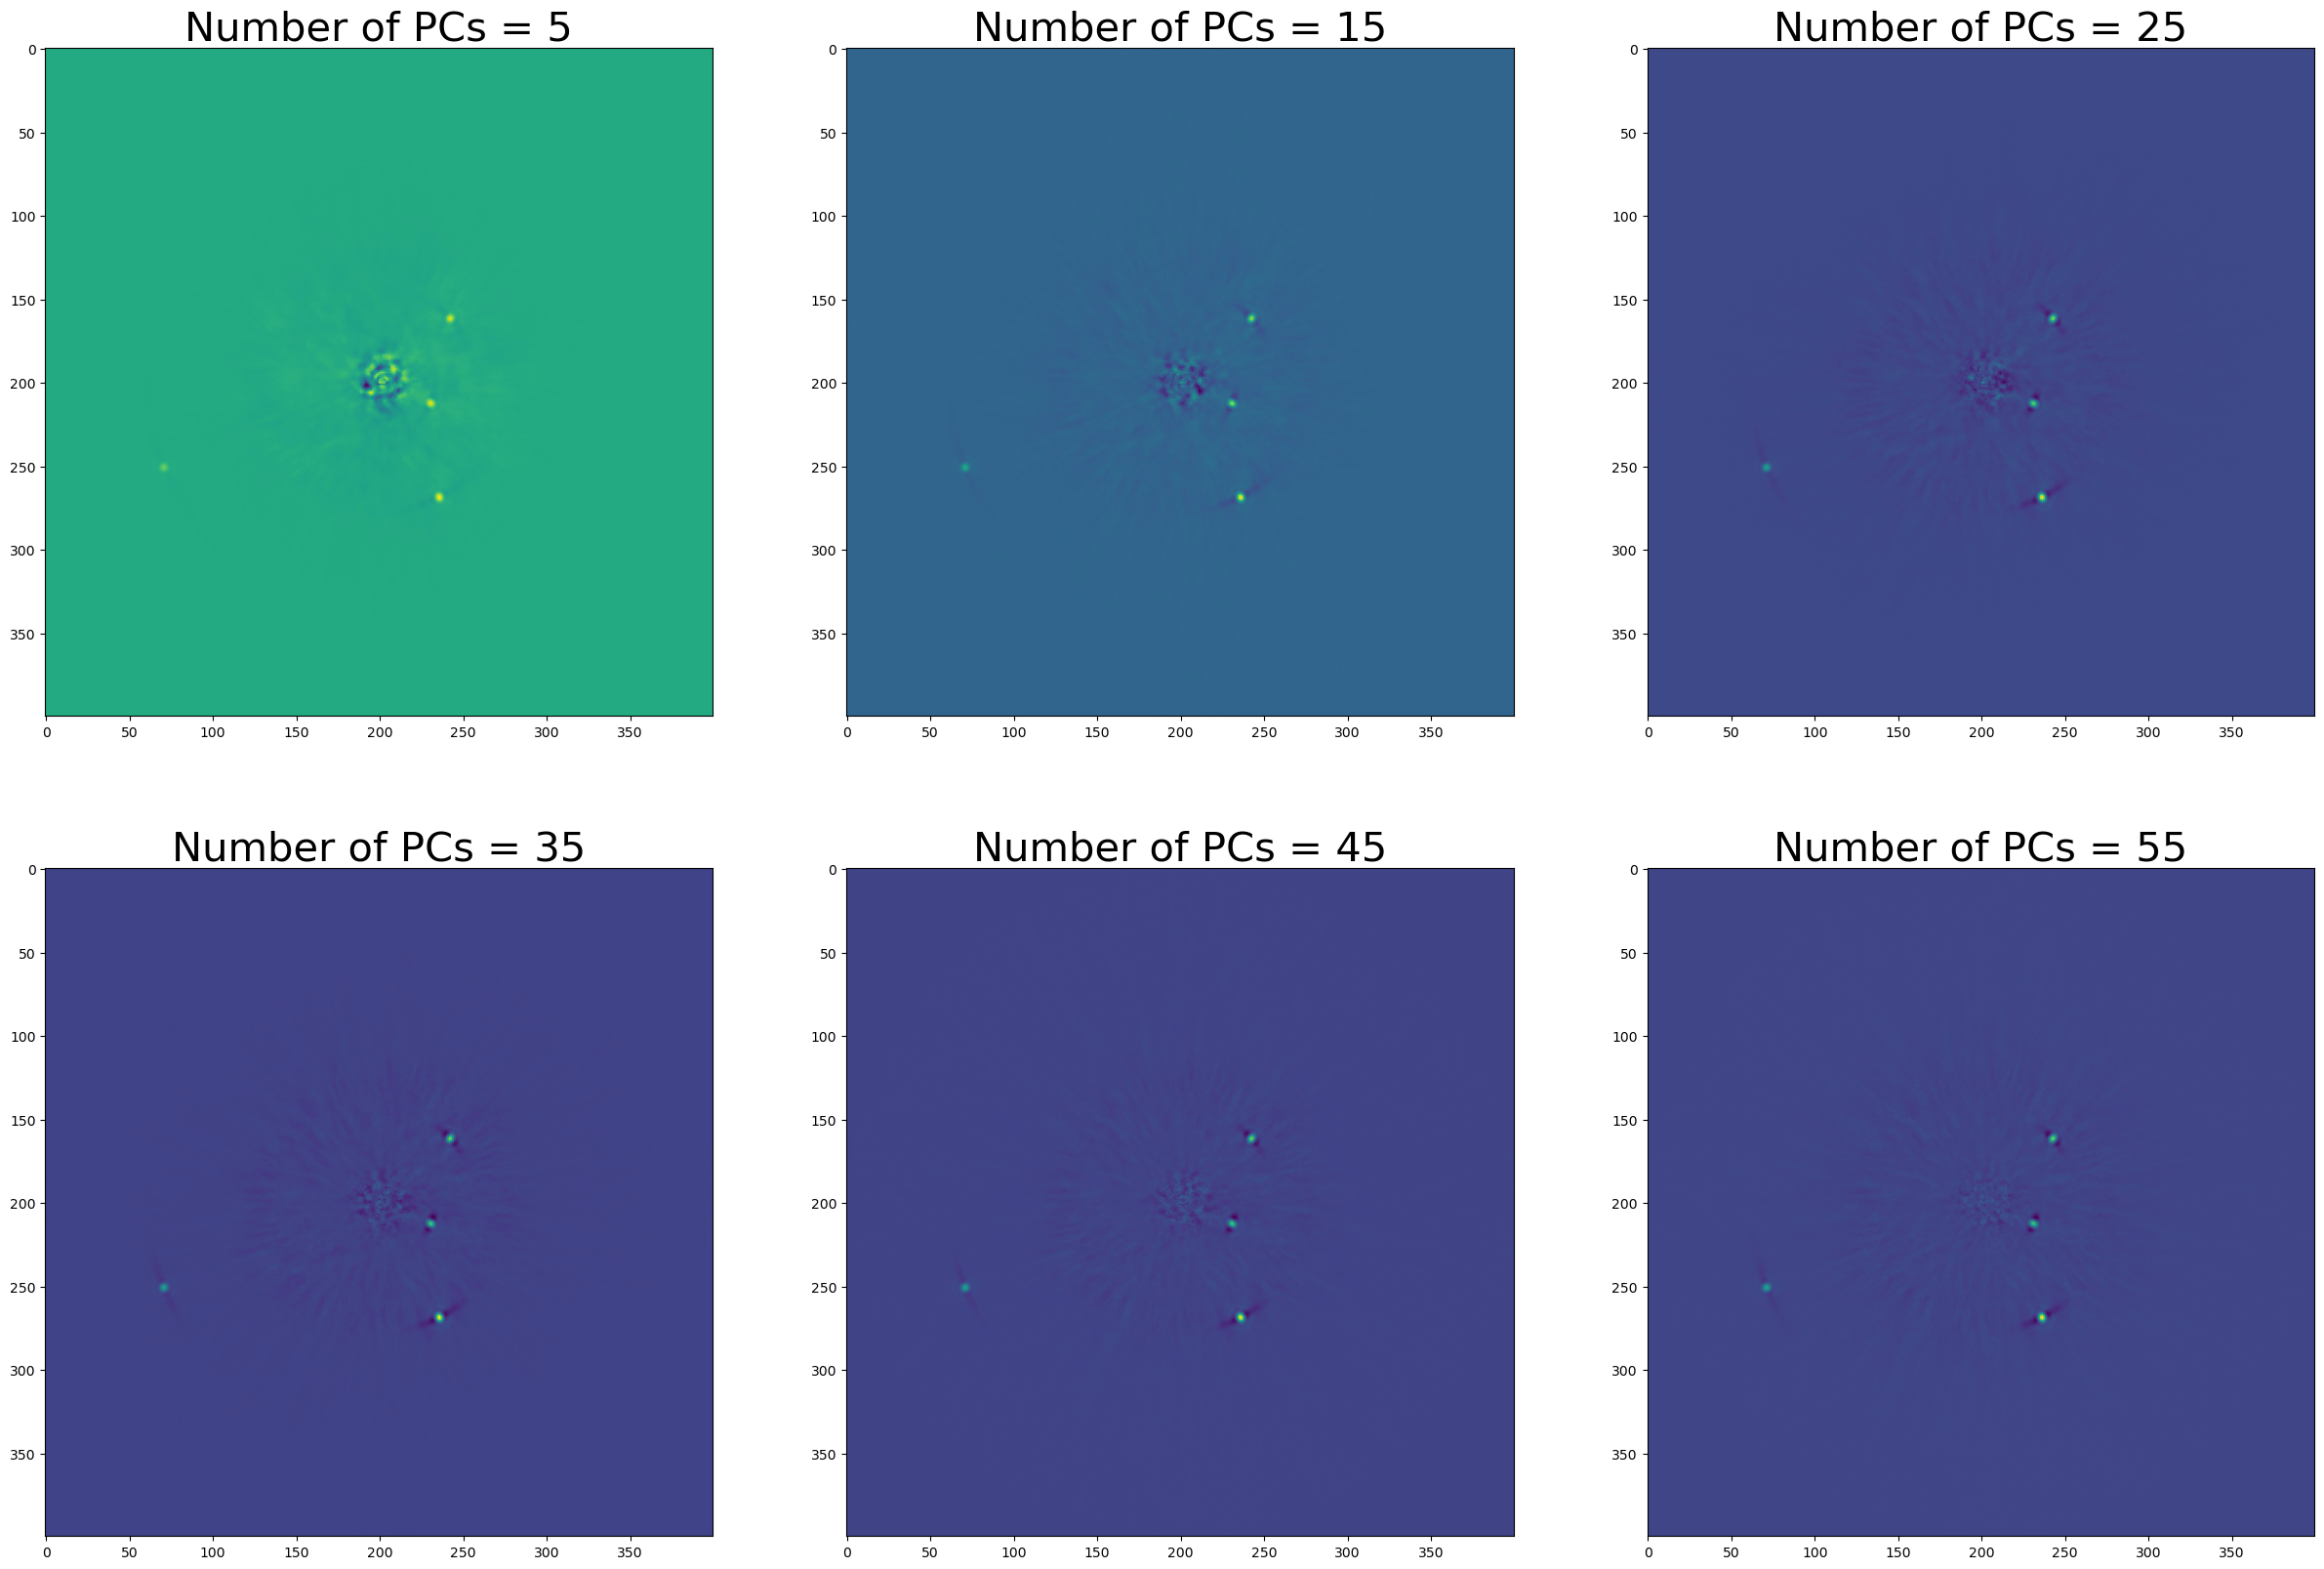

In [12]:
#plot results

fig = plt.figure(figsize=(30,20))

for i in np.arange(len(ncomps)):

    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(imstack[i])#, label = ncomps[i])
    ax.set_title('Number of PCs = ' + str(ncomps[i]), fontsize = 30)


#ax.legend(title = 'Number of PCs')

A few observations: 
1) the more principal components used, the better subtracted the speckle noise, but the longer the PCA takes to run.
2) the exoplanets don't look like perfect point sources -- they are super-imposed on a dark, angular streak.  This is the result of having light from the exoplanet in the stack of reference images used to build the KL-basis.  The dark streaks are due to self-subtraction of the planet from itself.  The more principal components used, the worse the self-subtraction will be.

Thus, choosing the best number of principal components to adopt is a balance between sufficient speckle suppression and minimising self-subtraction of each planet.  Let's use 35 principal components for the rest of this assignment, as this seems to provide a good balance between the two. 

## Image Analysis Step 1: find the on-sky separation between the planets and the star, compare with solar system planets

Like in workshop 4, we will use DAOStarFinder to find the positions of each planet.  We'll use the stacked image with 35 principal components subtracted, but you should find similar results with any of the stacked images from the last step.  Since you may want to run this step a few times, let's start by writing a convenience function to run DAOStarFinder and produce a table of sources:

In [13]:
def run_DAOStarFinder(im, fwhm, threshold):

    # use sigma_clipped_stats from astropy to calculate the mean median and std
    mean, median, std = sigma_clipped_stats(im)
        
    # run DAOStarFinder
    daofind = DAOStarFinder(fwhm = fwhm, threshold = threshold*std) 
    
    # get sources from DAOstarfinder
    sources = daofind(im - median) 

    return sources    

Let's start by running with fwhm = 4 pixels and a threshold of 100 times the standard deviation of the image.

In [14]:
sources = run_DAOStarFinder(imstack[3, :, :], 4., 100.) # 4, 100

Print out your resulting source table

In [15]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,242.28022800887277,161.5903296761675,0.43222771227528956,-0.4043558039268831,0.14859157024493286,25,0.0,14.924989700317383,4.175828262119104,-1.5518565731969018
2,193.67896092419141,196.5913627517015,0.36700730376131124,0.24360215734838933,-0.43615210258033077,25,0.0,1.6938927173614502,1.0707421710847604,-0.0742122691538479
3,192.50172153402144,202.44814300573034,0.3246235493056062,-0.6829420904667923,-0.3167224275973047,25,0.0,1.161490797996521,1.2168681360032678,-0.21310879785762307
4,211.8833247844792,202.49606214728902,0.4613107542814073,0.40317549155800825,0.031967437315680115,25,0.0,2.0054707527160645,1.1595576488408532,-0.160730862493442
5,230.6253084875249,212.56837986139496,0.42293564888346474,0.2395617463223304,-0.26399670433505024,25,0.0,12.857080459594727,3.798838920662275,-1.4491271971990902
6,70.82754218029295,250.80683891994417,0.38943864733937167,-0.010640532156612415,0.005819227911311389,25,0.0,9.001632690429688,2.3864268645012254,-0.9443703233110251
7,235.85030629950055,268.71948813367004,0.4085032572336661,0.4076201919517596,0.30286462896321914,25,0.0,19.745351791381836,5.345923338630309,-1.8200568165373843


Overplot the detected sources on the image

In [16]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)

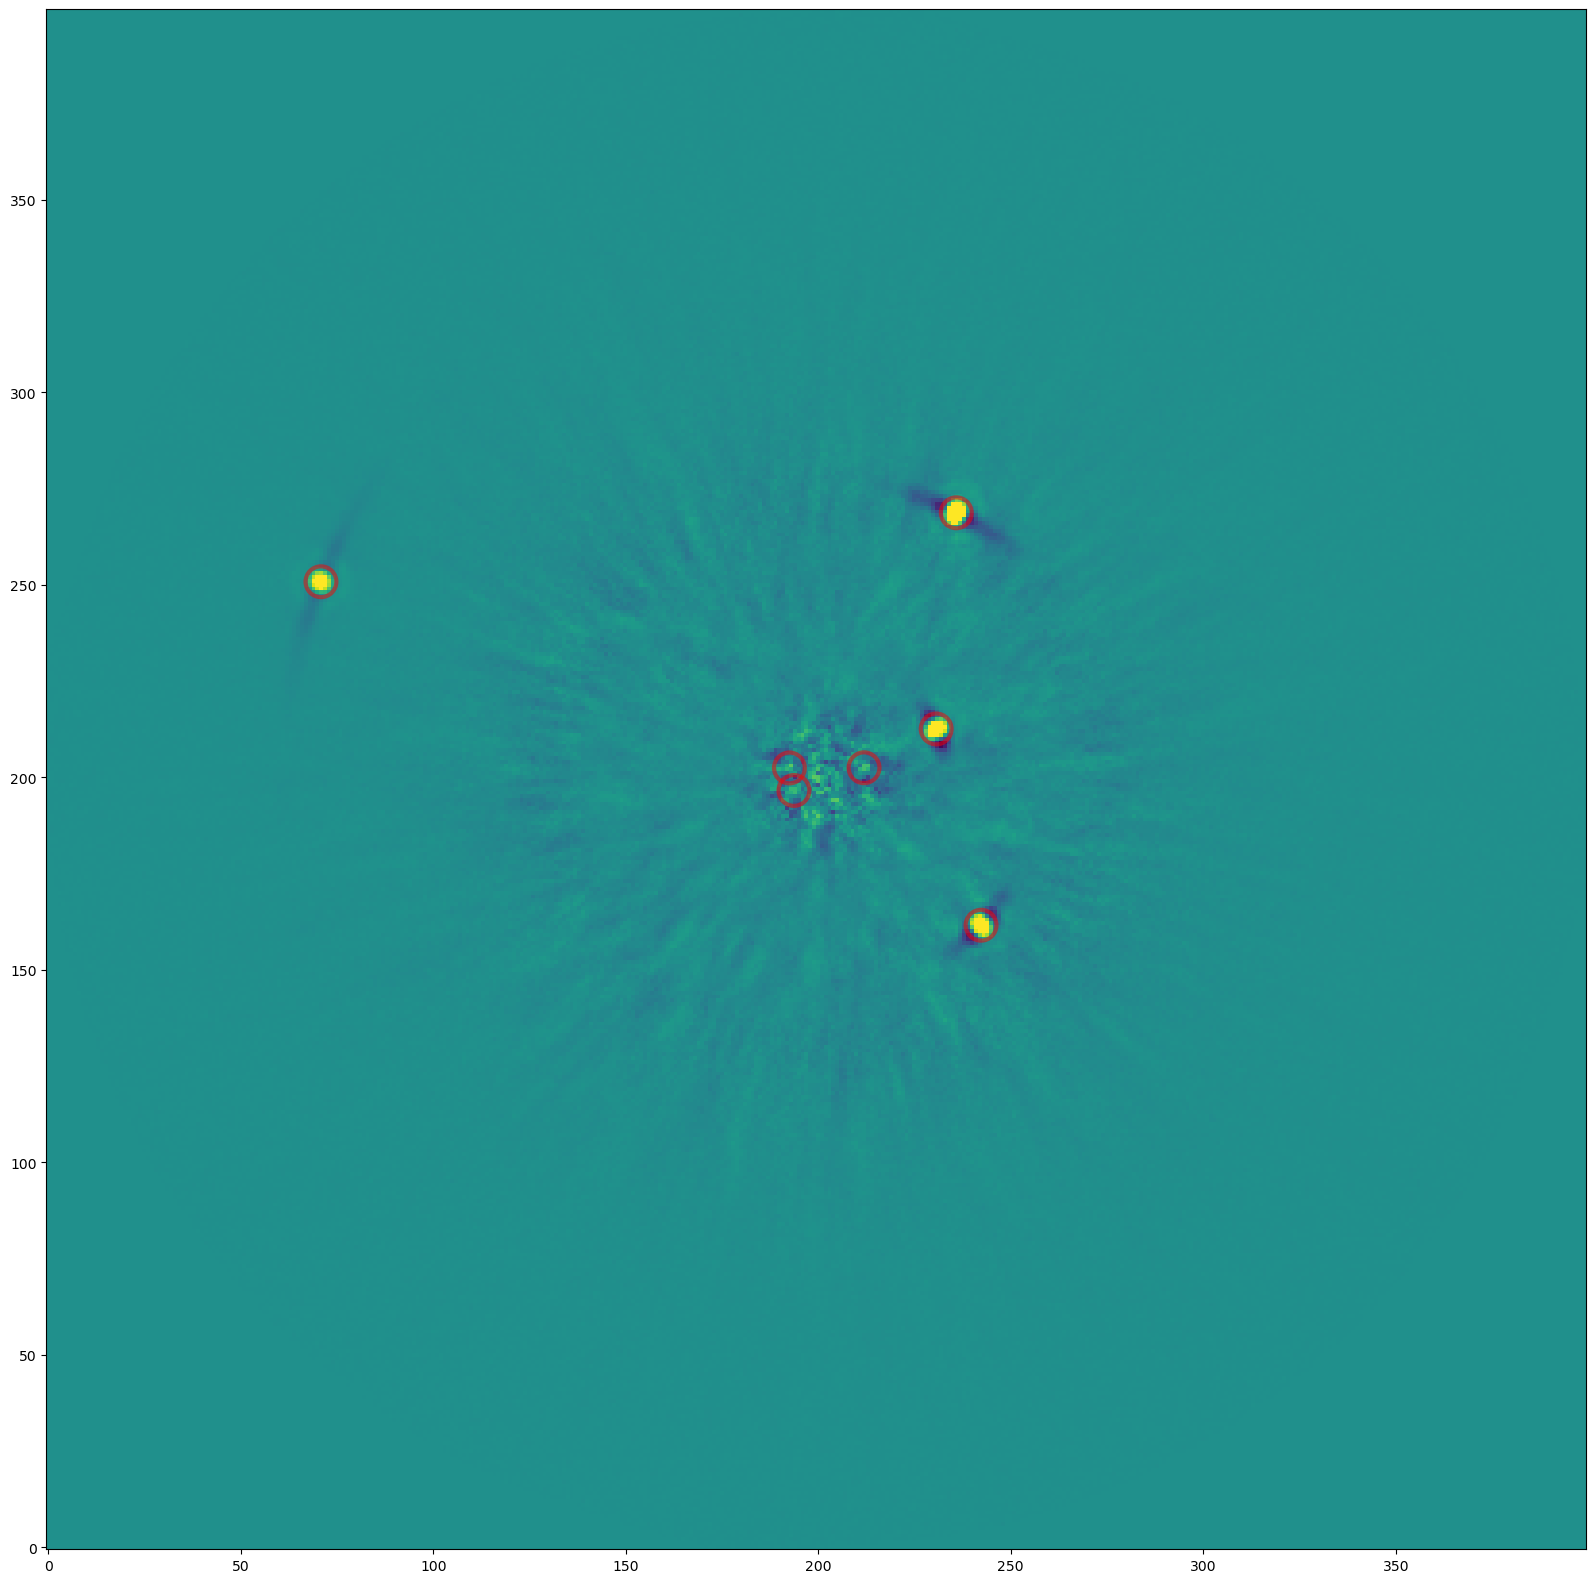

In [17]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

norm = ImageNormalize(imstack[3, :, :], vmin=-5, vmax=5)
ax.imshow(imstack[3, :, :], norm=norm, origin='lower')

apertures.plot(color='red', lw=3.0, alpha=0.5)

All 4 planets are detected, but so is a lot of other residual speckle noise left over in the core of the image.  Adjust fwhm and threshold until you robustly detect only the 4 planets.  Print out the resulting source table and replot the image with the detections of the exoplanets overlaid.

In [18]:
bestfwhm = 3.
bestthreshold = 100.
sources = run_DAOStarFinder(imstack[3, :, :], bestfwhm, bestthreshold)

In [19]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,242.28500340800136,161.58597519499796,0.4527769824195689,-0.4472541642245198,0.14826772582483427,25,0.0,14.924989700317383,2.721769551583407,-1.0871283782956853
2,230.6176917662024,212.56970113268085,0.4323537545070084,0.2539857990076539,-0.2640047675234457,25,0.0,12.857080459594727,2.5366217213695856,-1.0106392676100906
3,70.8273290540878,250.8077415194012,0.39431369830126767,0.009102663669389461,0.010941145753422532,25,0.0,9.001632690429688,1.5448026887608368,-0.47218254167617457
4,235.84504800177407,268.7149390282831,0.416783816413503,0.44713618019142076,0.30582853556239453,25,0.0,19.745351791381836,3.515839801162045,-1.3650726956855355


In [20]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)

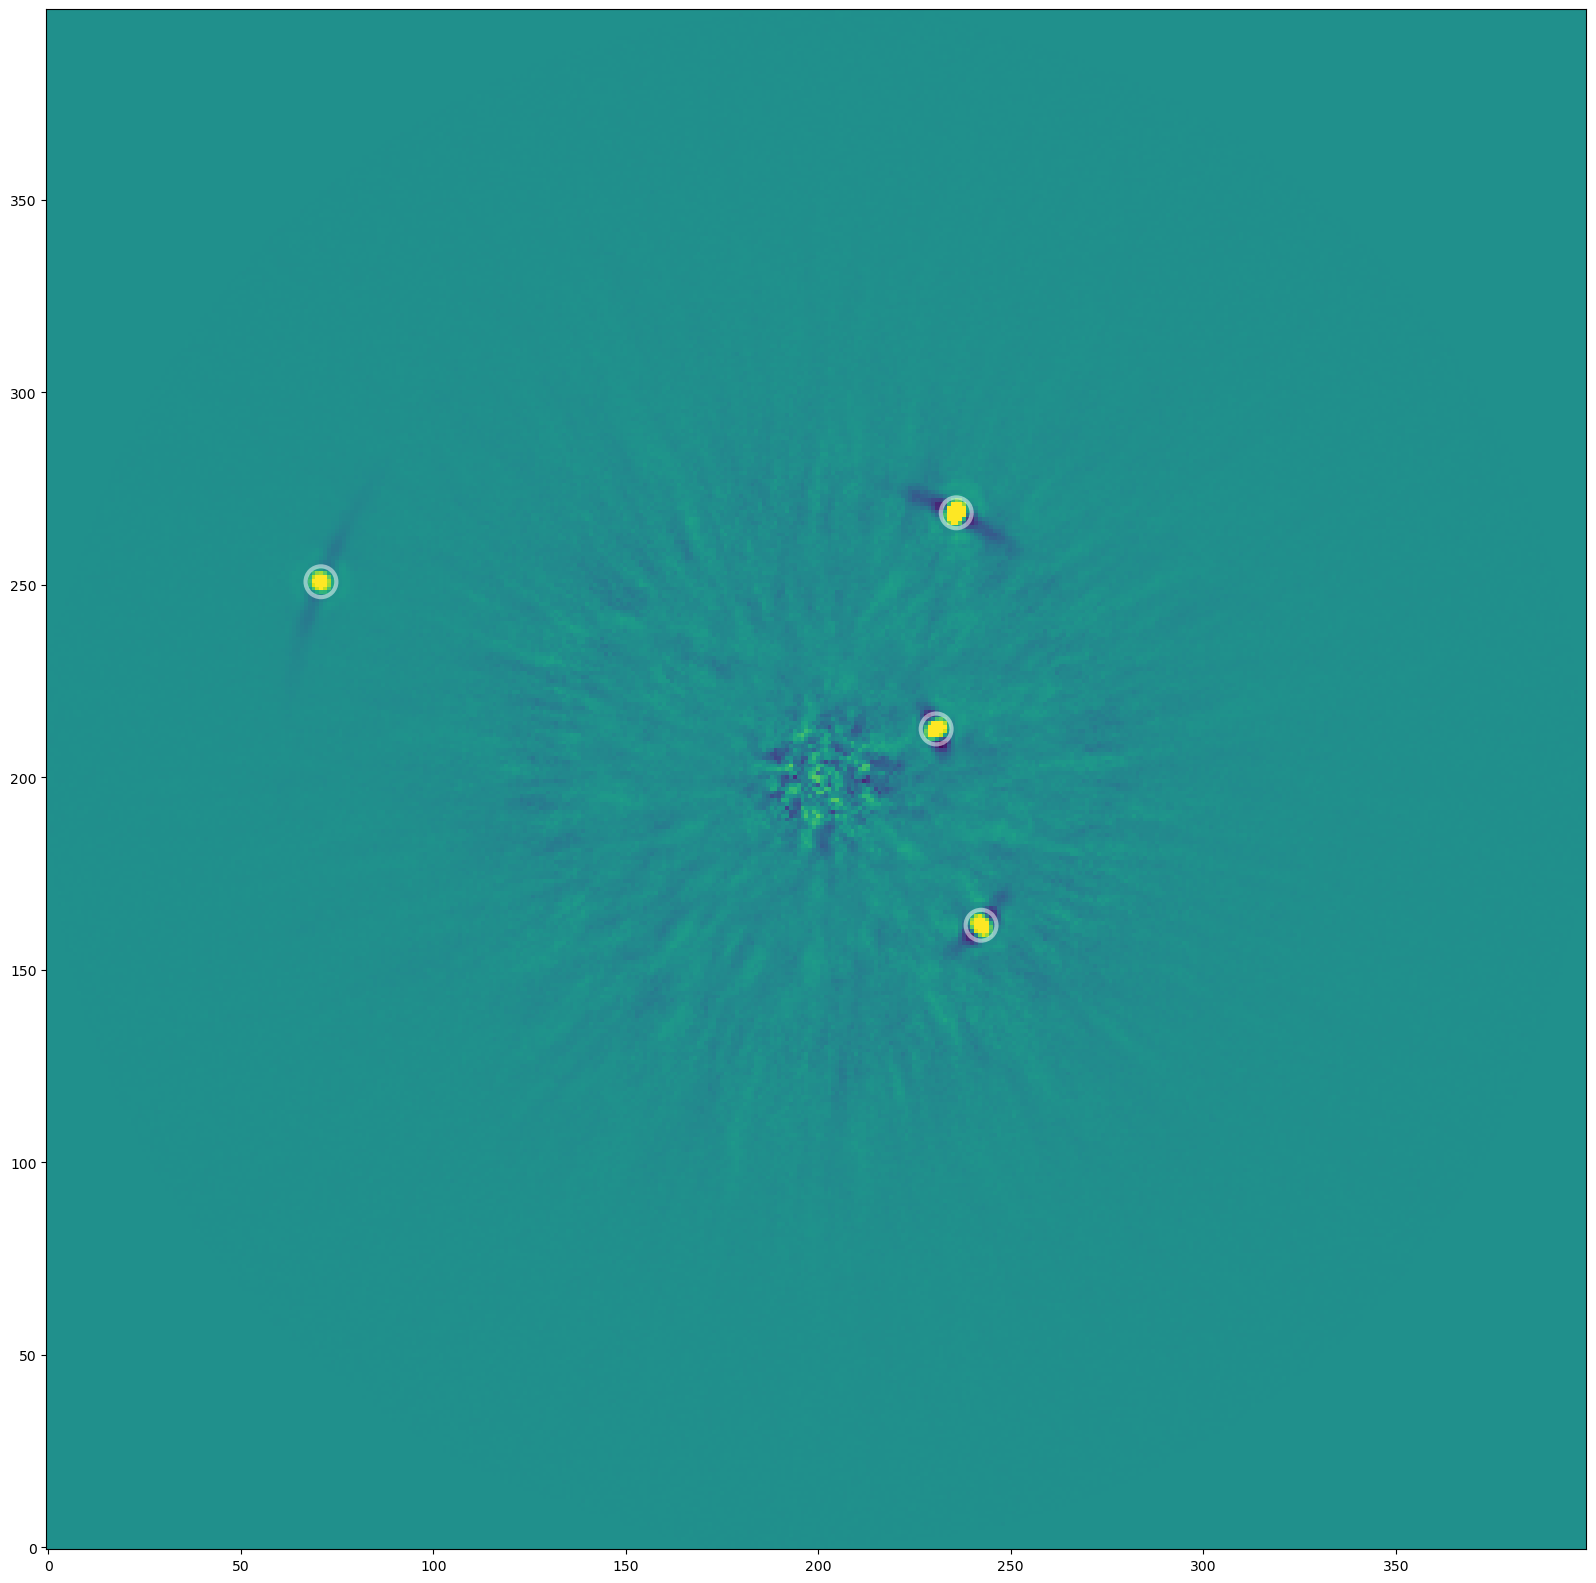

In [21]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

norm = ImageNormalize(imstack[3, :, :], vmin=-5, vmax=5)
ax.imshow(imstack[3, :, :], norm=norm, origin='lower')

apertures.plot(color='white', lw=3.0, alpha=0.5)

## Find position of planets in polar coordinates, i.e. radius, position angle (theta) units 

The centre of the image is at pixel 200, 200.  The convention for angles in astronomy place 0 degrees at North, with angles increasing positively anticlockwise from North.

In [22]:
xcen = 200.
ycen = 200.
r = np.sqrt(np.power(sources['xcentroid'] - xcen,2.) + np.power(sources['ycentroid'] - ycen,2.))
print(r)
theta = np.arctan2(-(sources['xcentroid'] - xcen), sources['ycentroid'] - ycen)

    xcentroid    
-----------------
57.12844138372758
33.09743850594931
138.8056393580722
77.50232455810696


Convert and print out your planet separations from units of pixels to units of arcseconds.  The pixel scale of the SPHERE detector is: 0.01225 arcsecond / pixel.

In [23]:
r_arc = r*0.01225
#theta = theta/0.01225

Now convert to units of astronomical units (AU).  1 AU is the average distance between the Earth and the Sun.  The distance to the HR 8799 system is 40.8 pc.  To convert to AU, you just need to multiply the separation in arcsec with the distance to the star in pc.

In [24]:
r_au = r_arc*40.8 # AU
print(r_au)
#theta = theta*40.8 # AU

    xcentroid     
------------------
28.552795003587047
16.542099765273466
 69.37505855116449
 38.73566181414186


How do these values compare with the semi-major axes of the orbits of gas giants like Jupiter and Saturn in our own solar system?

Jupiter has a semi major axis of ~ 5.2 AU, and Saturn has a semi major axis of ~ 9.58 AU. These are both smaller than the seperations of the planets in HR 8799, despite the central star having very similar properties to our own sun

Print out the position angles of each planet in degrees as well:

In [25]:
theta_deg = theta*180/np.pi # convert from radians to degrees
print(theta_deg)

     xcentroid     
-------------------
-132.25373567701524
 -67.68002643663829
  68.52869917524625
-27.548731812149924


## Image Analysis Step 2: Use simulated exoplanets to estimate the brightness and mass each of the planets

Since the PCA algorithm is not flux-conserving, we lose some (unquantified) amount of brightness from each planet when we run PCA.  Thus, unlike the seeing-limited image used in Workshop 4, we cannot simply perform aperture photometry to estimate the brightness of each planet.  Instead, we will use an image of the star taken without the coronagraph to simulate exoplanets in the raw data, then run PCA, and compare the brightness (after self-subtraction) of the simulated planets to the actual planets.  Let's start by inspecting the stellar image we will use to simulate the planets:

In [26]:
stellarim = fits.getdata('stellarim.fits')

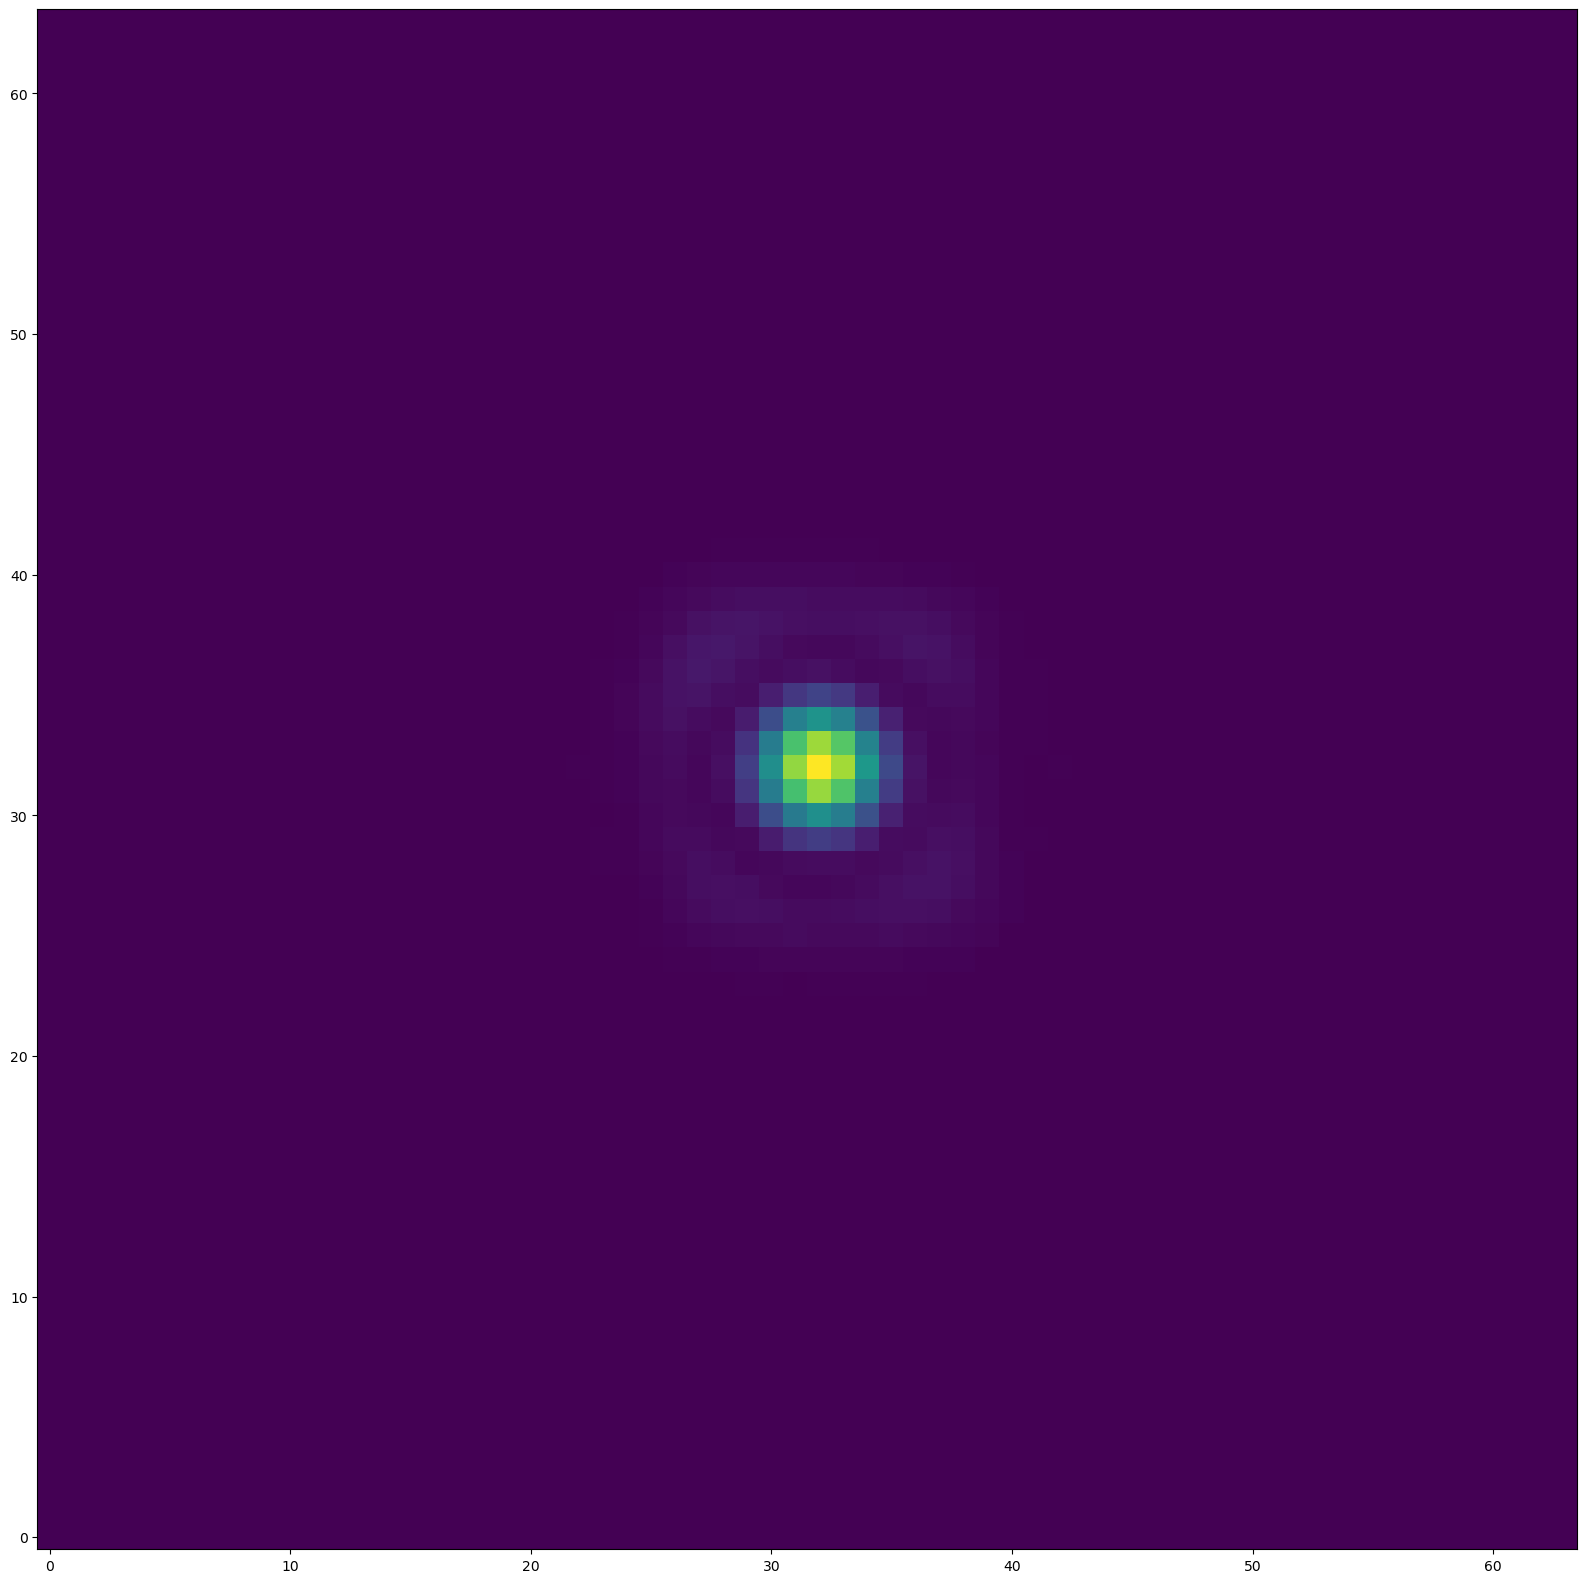

In [27]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

ax.imshow(stellarim, origin='lower')

This is an image of the star without the coronagraph taken right before the coronagraphic sequence you have been working with.  The original exposure time of the image was quite short to prevent saturation (in other words, hitting the brightness limit where the detector runs out of dynamic range), but the image was then scaled to the exposure time used for the coronagraphic sequence.  Now let's write another convenience function, to make a cube of simulated planet images at the correct position angle for each image in the sequence.  It should take the data cube, stellar image, and array of parallactic angles as input, and simulate an exoplanet at a radius of rad pixels, with position angle theta, and at some delta(magnitude) dmag fainter than the primary star.  

In [28]:
def simulate_object(data, stellarim, pararr, rad, theta, dmag, xcen=200, ycen=200, imdiam=400):
    # goal of function: make an image cube with just simulated objects

    # make an array with the same dimensions as the inputted data cube, but filled with only zeros.  Hint: try using np.zeros
    psfcube = np.zeros_like(data)   

    # put small stellar image into the center of an image with the same shape as each slice of the data cube, but composed only of zeros.
    #get shapes of image and smaller image

    x2, y2 = stellarim.shape # get shape of stellar image
    
    psfpadded = np.zeros([imdiam, imdiam]) # create zeros array of same size as dataslice
    
    x_pad = int(x2/2) # number of pixels to pad in the x direction
    y_pad = int(y2/2) # number of pixels to pad in the y direction
    
    psfpadded[xcen-x_pad:xcen+x_pad, ycen-y_pad:ycen+y_pad] = stellarim # set central region of zeros array to the stellar im
    
    # figure out the appropriate position of the simulated object 
    xshifts = -rad * np.sin((pararr + theta) * (np.pi/180.))
    yshifts = rad * np.cos((pararr + theta) * (np.pi/180.))
    
    # for each slice in the array with the same dimensions as the inputted cube, insert the simulated planet image at the right position
    for i in tqdm(np.arange(data.shape[0])):
        psfcube[i,:,:] = ndimage.shift(psfpadded, (yshifts[i], xshifts[i]))
        
    # Scale simulated planet images to the input Delta(mag) value
    psfcube = psfcube * 10**(-dmag / 2.5)
    
    return(psfcube)


Simulate a test object 4 magnitudes fainter than the star, at a radius of 100 pixels and a position angle of 60 degrees.

In [29]:
simcube = simulate_object(imcube, stellarim, pararr, 100., 60, 4) # 4
print(simcube.shape)

100%|██████████| 896/896 [00:08<00:00, 100.71it/s]


(896, 400, 400)


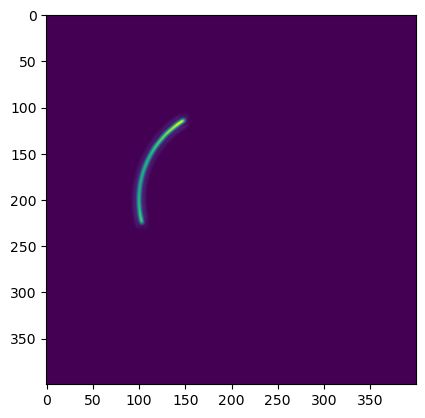

In [30]:
summed = np.sum(simcube, axis = 0)
plt.imshow(summed)

Plot a few frames from the resulting cube to see what this looks like:

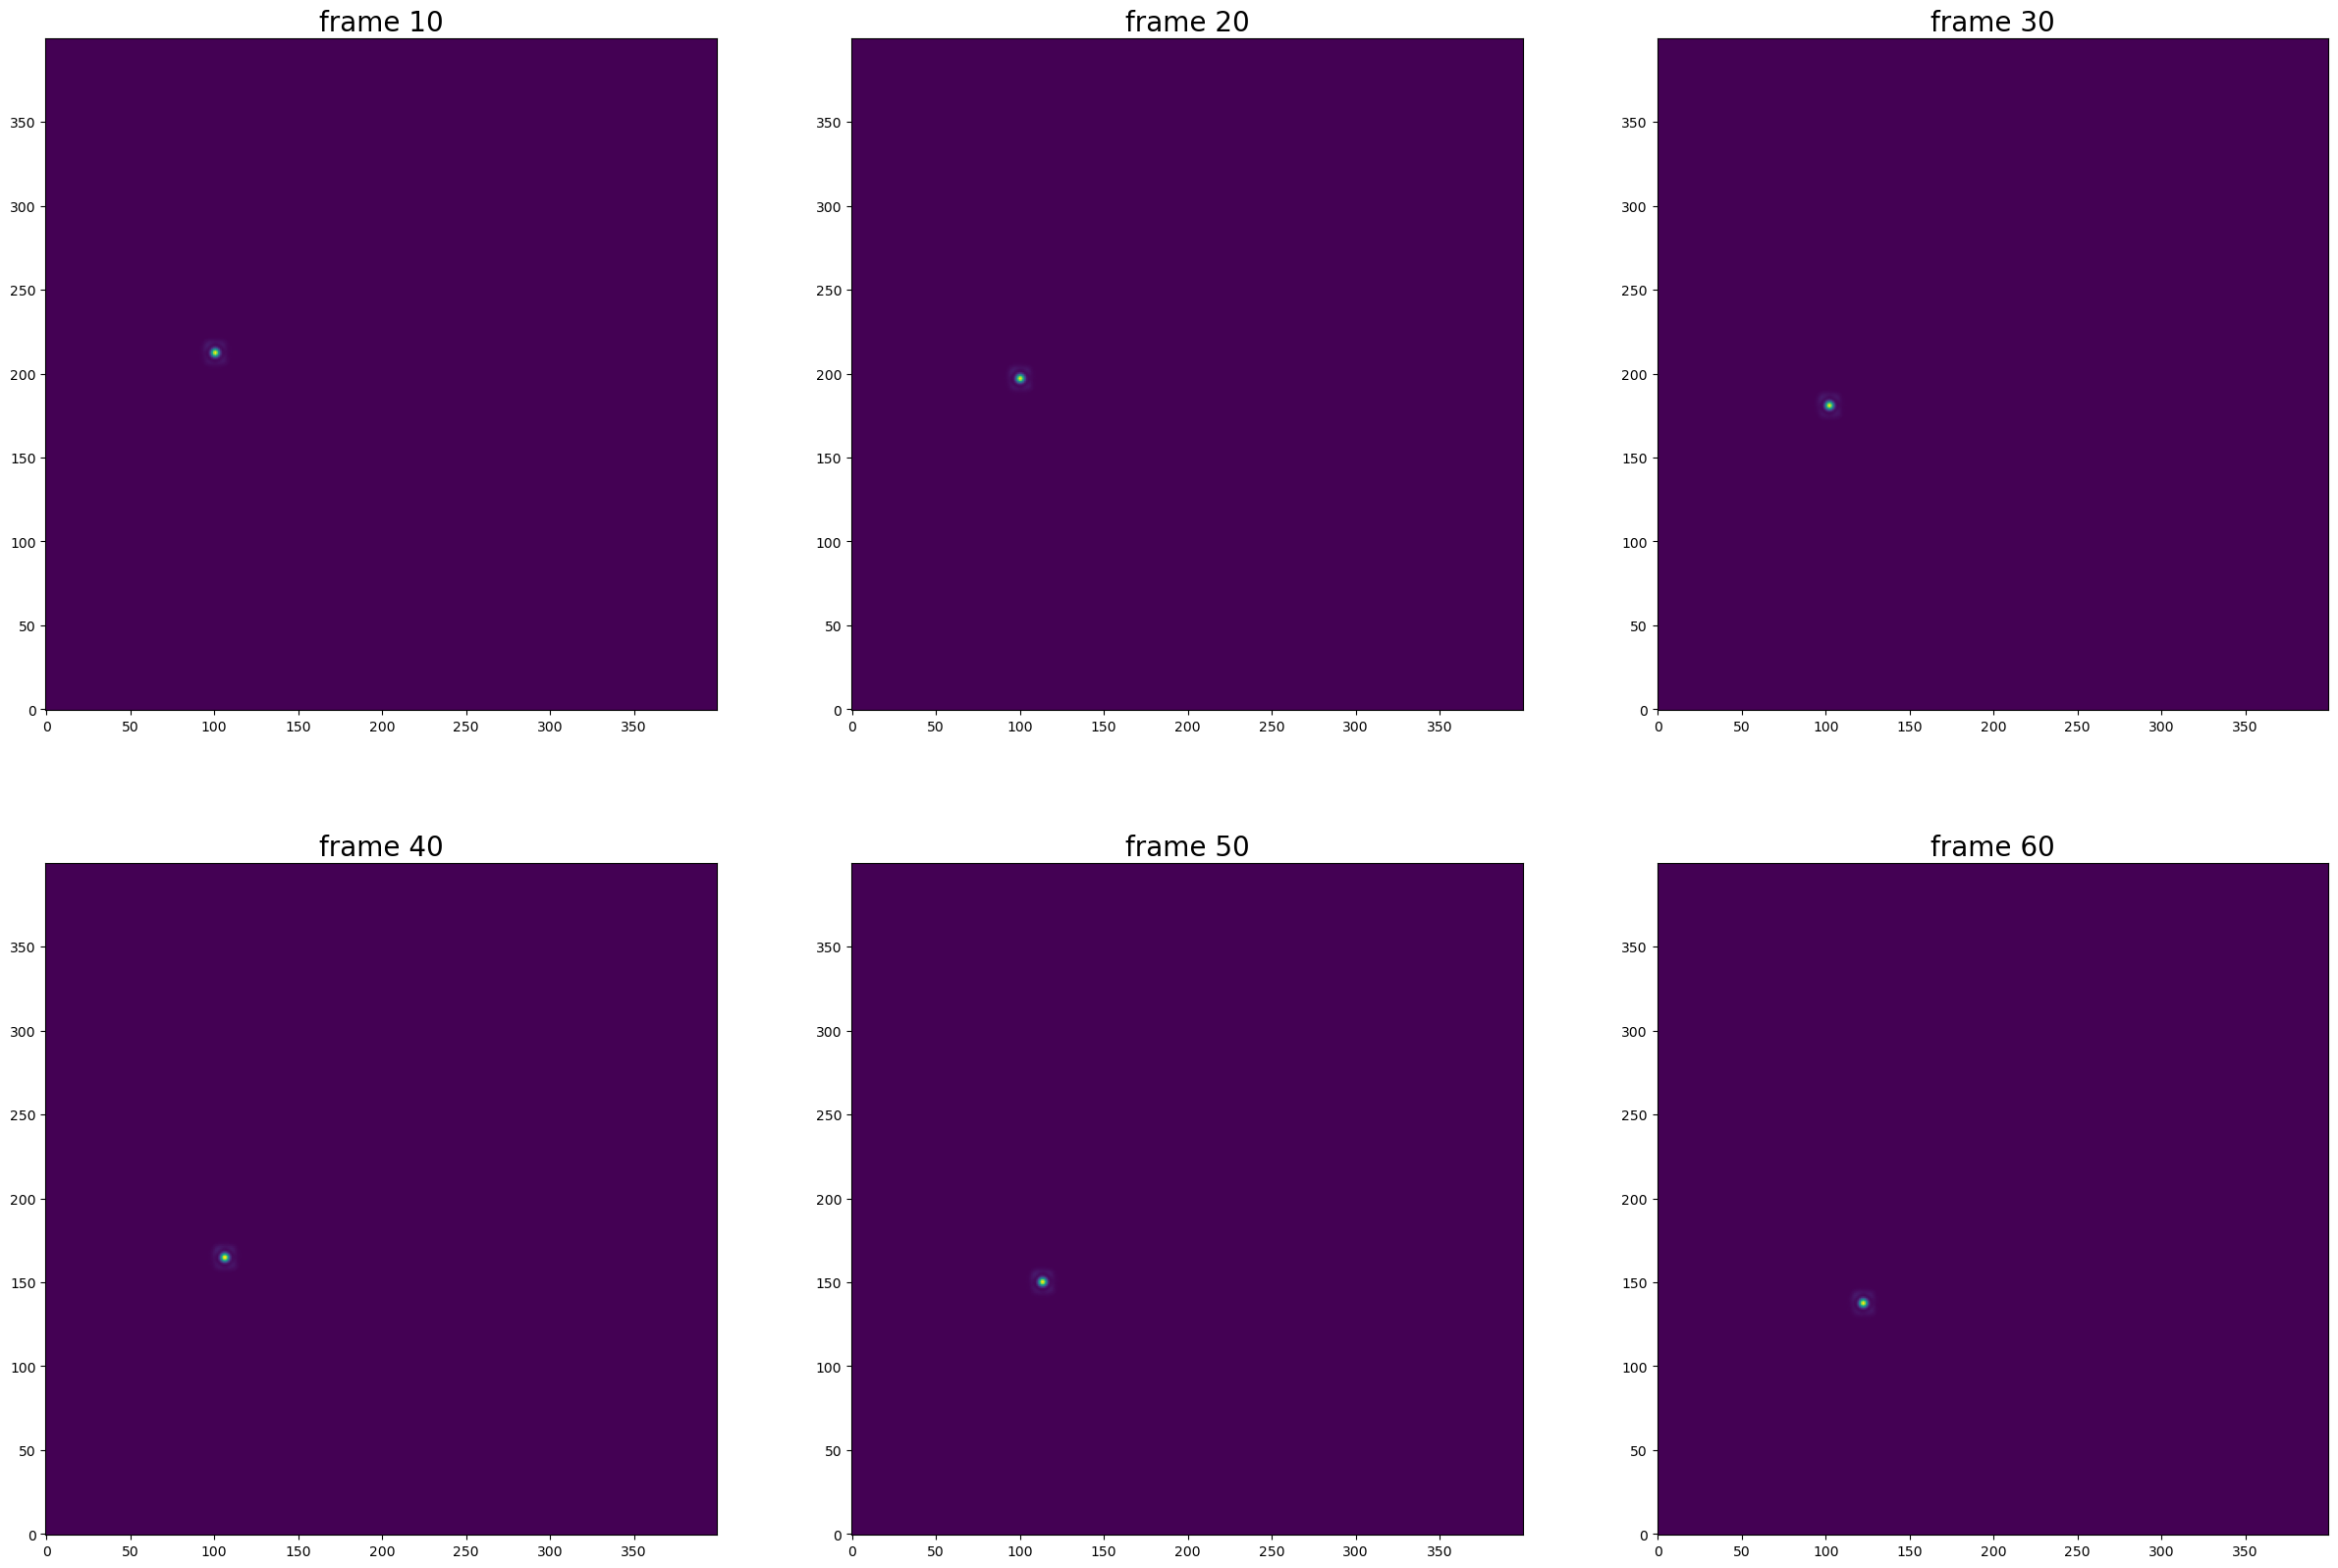

In [31]:
#plot results

fig = plt.figure(figsize=(30,20))

for i in np.arange(6):

    ax = fig.add_subplot(2, 3,i+1)

    norm = ImageNormalize(simcube[(i+1)*100, :, :], vmin=-5, vmax=5)
    ax.imshow(simcube[(i+1)*100, :, :], origin='lower')
    ax.set_title('frame '+str((i+1)*10), fontsize=20)

Now add your simulated object cube to the image cube and rerun PCA.  You'll need to remake the covariance matrix with the new data cube that includes the simulated object.  In fact, go ahead and write a convenience function to build the covariance matrix.

Add the simulated object to the data cube and rerun the PCA

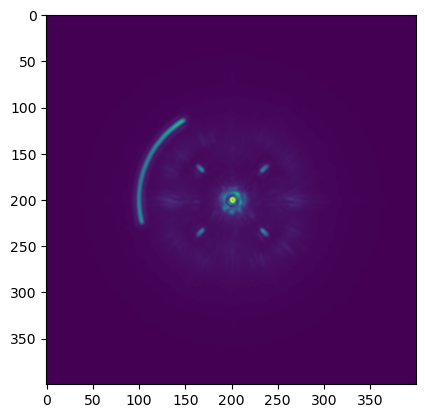

In [32]:
# add simulated object to data cube
datawithsimobject = imcube + simcube

plt.imshow(np.sum(datawithsimobject, axis = 0))

In [33]:
# add simulated object to data cube
datawithsimobject = imcube + simcube

# rerun PCA with 35 principal components.  You'll need to remake the covariance matrix in this case.
covar_psfs2, ref_psfs_mean_sub2 = make_cov_matrix(datawithsimobject)
imsimobject = run_full_PCA(covar_psfs2, ref_psfs_mean_sub2, datawithsimobject, pararr, numbasis=35)

  7%|▋         | 62/896 [00:03<00:48, 17.34it/s]


KeyboardInterrupt: 

Display the resulting image.  You've simulated a very bright object, so you shouldn't see the planets.

In [ ]:
# plot result
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)

ax.imshow(imsimobject, origin='lower')

Now that your simulation code is working, let's simulate a faint exoplanet.  Simulate an object at the same radius and position angle as before, but with dmag = 12.5.

In [34]:
simcube = simulate_object(imcube, stellarim, pararr, 100., 60., 12.5)

100%|██████████| 896/896 [00:08<00:00, 100.14it/s]


Rerun PCA and display the resulting image:

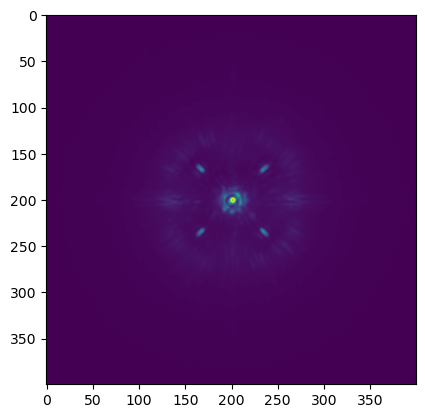

In [35]:
imcubewithsimobject = imcube + simcube
plt.imshow(imcubewithsimobject[0])

In [36]:
# add simulated object to data cube
imcubewithsimobject = imcube + simcube

In [37]:
# add simulated object to data cube
# imcubewithsimobject = imcube + simcube

# rerun PCA with 35 principal components.  You'll need to remake the covariance matrix in this case.
covar_psfs3, ref_psfs_mean_sub3 = make_cov_matrix(imcubewithsimobject)
median_filter3 = run_full_PCA(covar_psfs3, ref_psfs_mean_sub3, imcubewithsimobject, pararr, numbasis=35)

100%|██████████| 896/896 [00:48<00:00, 18.55it/s]


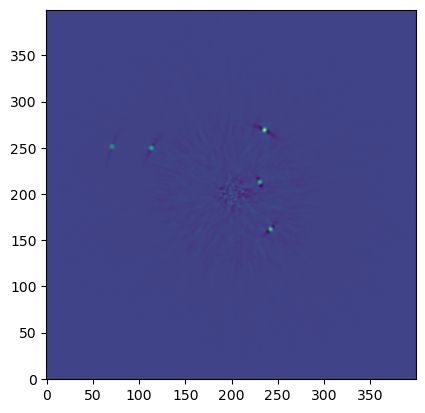

In [38]:
# plot result
plt.imshow(median_filter3, origin = 'lower')

You can see that a planet 12.5 magnitudes fainter than the star is not too far off in appearance to the actual planets.  Let's first simulate some more planets at the separation of each of the actual planets and see if we can match the brightness of each planet in turn with a simulated version.  Let's start by simulating a Delta(mag)=12.5 planet at the separation of each of the 4 planets, but offset by 40 degrees in position angle.

In [39]:
# Simulate 4 planets with delta(mag) = 12.5, 40 degrees offset from each actual planet

def sim_multiple_planets(imcube, stellarim, pararr, radii, separations, offset, magnitude):
    '''
    Add multiple simulated planets to an image cube
    
    imcube = 3d array with star
    stellarim = smaller version of star 
    
    '''
    imcubewithplanets = np.zeros_like(imcube)
    
    for i in range(len(r)):

        print(f'Planet {i+1}:')
        # make simulated planet
        sim_planet = simulate_object(imcube, stellarim, pararr, radii[i], separations[i] + offset, magnitude)
    
        # add simulated object to imcube
        imcubewithplanets = imcubewithplanets + sim_planet
    
    return imcubewithplanets

In [40]:
sim_planets = sim_multiple_planets(imcube, stellarim, pararr, r, theta_deg, 40, 12.5)

Planet 1:


100%|██████████| 896/896 [00:09<00:00, 90.44it/s]


Planet 2:


100%|██████████| 896/896 [00:10<00:00, 85.48it/s]


Planet 3:


100%|██████████| 896/896 [00:08<00:00, 109.29it/s]


Planet 4:


100%|██████████| 896/896 [00:09<00:00, 92.56it/s]


Re-run the PCA analysis, plot the resulting image

In [41]:
# add simulated object to data cube
imcubewithsimplanets = imcube + sim_planets

# rerun PCA with 35 principal components
covar_psfs4, ref_psfs_mean_sub4 = make_cov_matrix(imcubewithsimplanets)
median_filter4 = run_full_PCA(covar_psfs4, ref_psfs_mean_sub4, imcubewithsimplanets, pararr, numbasis=35)


100%|██████████| 896/896 [00:48<00:00, 18.43it/s]


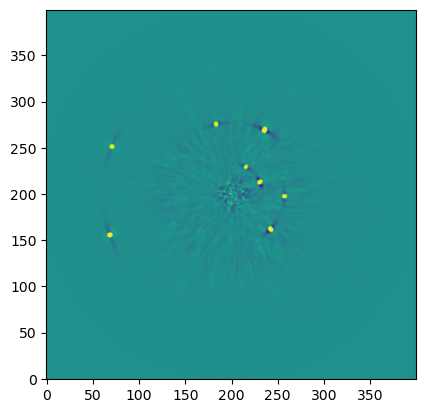

In [42]:
# plot result
plt.imshow(median_filter4, origin = 'lower', vmin = -5, vmax = 5)

Let's try simulating exoplanets with Delta(mag) values ranging from 11.5 to 13.1, in steps of 0.2 mag, in the same positions as in the last example, and save the results in a stack of images (like we did when testing out the number of principal components to retain).  

In [ ]:
# simulate exoplanets at a range of Delta(mag) values
dmags = np.arange(11.5, 13.2, 0.2)

# set up data stack
magstack = np.zeros((len(dmags), imcube.shape[1], imcube.shape[2]))

for j in range(len(magstack)):

    print(f'Magnitude = {dmags[j]}')
    # simulate the 4 planets
    sim_planets = sim_multiple_planets(imcube, stellarim, pararr, r, theta_deg, 40, dmags[j])
    
    # add the 4 planets to imcube
    add_planets = imcube + sim_planets
    
    # perform PCA
    covar_psfs5, ref_psfs_mean_sub5 = make_cov_matrix(add_planets)
    magstack[j] = run_full_PCA(covar_psfs5, ref_psfs_mean_sub5, add_planets, pararr, numbasis=35)


Magnitude = 11.5
Planet 1:


100%|██████████| 896/896 [00:09<00:00, 90.55it/s]


Planet 2:


100%|██████████| 896/896 [00:10<00:00, 85.23it/s]


Planet 3:


100%|██████████| 896/896 [00:08<00:00, 111.90it/s]


Planet 4:


 66%|██████▌   | 587/896 [00:34<00:17, 17.92it/s]

In [ ]:
#plot results

fig = plt.figure(figsize=(10, 10*len(dmags)))

for i in np.arange(len(dmags)):

    ax = fig.add_subplot(len(dmag),3,i+1)
    ax.imshow(magstack[i])#, label = ncomps[i])
    ax.set_title(f'Magnitude = {round(dmag[i], 1)}', fontsize = 10)

  

You can see by eye which of the simulated planets best match the actual observed planets.  With your project partner, go through the set of images you have plotted above and agree on the best matching Delta(mag) value for each planet.  HR 8799b is the furthest out of the planets, with HR 8799c, d, and e each successively closer in planet.

In [ ]:
planet_dmags = []

### Use your Delta(mag) estimates with an evolutionary model for exoplanets to estimate the mass of each planet

The absolute magnitude of HR 8799 (the star) in H band is: 2.22.  This is the magnitude of the star you would measure if you were a distance of 10 pc away from the star, and is essentially a measure of the star's intrinsic luminosity.  You've just found out how much fainter each planet is compared to the star in units of magnitudes.  Now calculate the absolute magnitude for each planet.  (Hint: this is just the Delta(mag) you've just found plus the absolute magnitude of the star.)

In [ ]:
# calculate the absolute magnitude of each planet


We'll now use the absolute magnitudes to estimate a mass for each planet from an evolutionary model.  This is a model that tracks the luminosity of brown dwarfs and giant exoplanets as they cools and dims with time.  Thus, if we know the absolute magnitude of a planet and also its age, we can estimate the mass that this corresponds to in the model.  You've just found the absolute magnitudes of each planet and the age of this star is about 50 million years.  The model is in a ascii table with two columns: mass (in Jupiter masses) and absolute H mag, Mh.

In [ ]:
model = Table.read('DUSTY_Hband_50Myr.txt', format='ascii')

In [ ]:
model

Use scipy.interpolate.interp1d to estimate the masses of each planet:

In [ ]:
f = interpolate.interp1d(model['Mh'], model['Mass'])

masses = f(planet_dmags + 2.22)

Print out your estimates for the masses of the planets.

In [ ]:
masses

How do the masses of the HR 8799 planets compare with the masses of gas giants in our own solar system?

# Change Log: please use the markdown cells at the end of the notebook to keep track of changes made by you and your project partner.